In [494]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [320]:
import tensorflow as tf

### Parsing sound data

In [267]:
def parse_sounds(path):
    S, features, labels = [], np.empty((0,187)), np.empty(0)
    for filename in os.listdir(path):
        if filename.startswith(""):
            X, sample_rate = librosa.load(path+filename) 
            
            spectr = librosa.feature.melspectrogram(X, sr=sample_rate)
            
            S.append(spectr)
            
            mfccs,chroma,mel,contrast = extract_sound_features(X, sample_rate)
            
            ext_features = np.hstack([mfccs,chroma,mel,contrast])
            features = np.vstack([features,ext_features])  
                        
            label = filename.split(".")[0].split("_")[1]
            labels = np.append(labels, label)
            
    return S, np.array(features), np.array(labels, dtype = np.int)

def extract_sound_features(X, sample_rate):
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,
                    axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,
                     axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,
                  axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,
                       axis=0)
    return mfccs,chroma,mel,contrast

In [268]:
path = "C:/Neat/Study/диплом/data/ready/"

S, X, y = parse_sounds(path)

In [391]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels-1] = 1
    return one_hot_encode

Y_train = one_hot_encode(y_train)
Y_test = one_hot_encode(y_test)

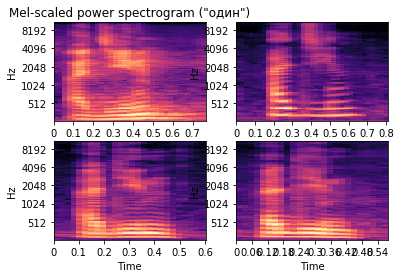

In [262]:
plt.subplot(2, 2, 1)
plt.title('Mel-scaled рower spectrogram ("один")')
librosa.display.specshow(librosa.power_to_db(S[0], ref=np.max), y_axis='mel', x_axis='time')

plt.subplot(2, 2, 2)
librosa.display.specshow(librosa.power_to_db(S[50], ref=np.max), y_axis='mel', x_axis='time')

plt.subplot(2, 2, 3)
librosa.display.specshow(librosa.power_to_db(S[100], ref=np.max), y_axis='mel', x_axis='time')

plt.subplot(2, 2, 4)
librosa.display.specshow(librosa.power_to_db(S[150], ref=np.max), y_axis='mel', x_axis='time')

plt.show()

### Splitting data

In [594]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=100, 
                                                    random_state=42, 
                                                    stratify=y)

In [595]:
S_train, S_test, y_train, y_test = train_test_split(S, y,
                                                    test_size=100, 
                                                    random_state=42, 
                                                    stratify=y)

### Baseline models (trained on conventional sound features)

In [367]:
c = RandomForestClassifier(random_state=42, 
                           n_estimators=500)

print("cross-val score", cross_val_score(c, X, y).mean())

cross-val score 0.205925925926


In [365]:
clf = RandomForestClassifier(random_state=42, 
                             n_estimators=500)

clf.fit(X_train, y_train)

results = clf.predict(X_test)

print("accuracy", metrics.accuracy_score(y_test, results))

# for label, result in sorted(zip(y_test, results), key=lambda x: x[0]):
#     if label == result:
#         print(label, "\t", result, "\t", "+")
#     else:
#         print(label, "\t", result)

accuracy 0.16


In [363]:
c = svm.SVC(kernel="poly")

print("cross-val score", cross_val_score(c, X, y).mean())

cross-val score 0.16


In [371]:
clf = svm.SVC(kernel="poly")

clf.fit(X_train, y_train)

results = clf.predict(X_test)

print("accuracy", metrics.accuracy_score(y_test, results))

# for label, result in sorted(zip(y_test, results), key=lambda x: x[0]):
#     if label == result:
#         print(label, "\t", result, "\t", "+")
#     else:
#         print(label, "\t", result)

accuracy 0.19


### Neural network model (trained on conventional sound features)
Made with TensorFlow
<br>Inspiration from Urban Sound Classification by Aaqib Saeed

- two hidden layers 
- (300+300 neurons)
- nonlinear activation functions: tanh + sigmoid

In [505]:
training_epochs = 60000
n_dim = X_train.shape[1]
n_classes = 50
n_hidden_units_one = 300 
n_hidden_units_two = 300
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.00001

In [506]:
X_ = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X_,W_1) + b_1)

W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], 
                                   mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)

W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.global_variables_initializer()

In [507]:
cost_function = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

--- 9179.503327846527 seconds ---
Test accuracy:  0.33


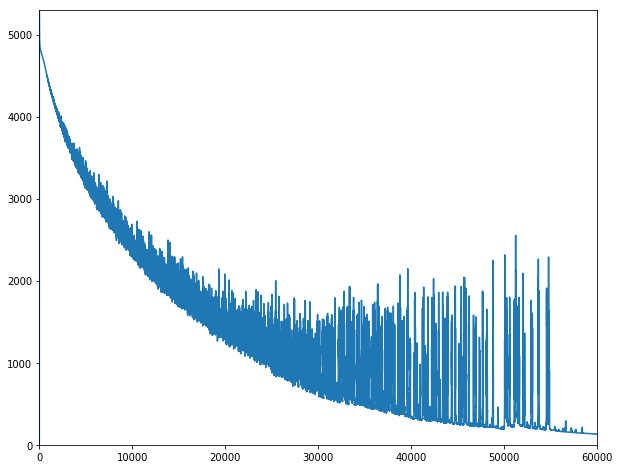

F-Score: 0.33


In [508]:
start_time = time.time()

cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):   
        if epoch % 100 == 0:
            print(epoch, "epochs", end='\r')
        _,cost = sess.run([optimizer,cost_function],feed_dict={X_:X_train,Y:Y_train})
        cost_history = np.append(cost_history,cost)
    
    end_time = time.time()
    print("--- %s seconds ---" % (end_time - start_time))
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X_: X_test})
    y_true = sess.run(tf.argmax(Y_test,1))
    print("Test accuracy: ",round(sess.run(accuracy, 
                                              feed_dict={X_: X_test,Y: Y_test}),3))
    
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = metrics.precision_recall_fscore_support(y_true, y_pred, average="micro")
print("F-Score:", round(f,3))

In [510]:
for label, result in sorted(zip(y_true, y_pred), key=lambda x: x[0]):
    if label == result:
        print(label+1, "\t", result+1, "\t", "+")
    else:
        print(label+1, "\t", result+1)

1 	 13
1 	 1 	 +
2 	 2 	 +
2 	 40
3 	 43
3 	 23
4 	 3
4 	 3
5 	 15
5 	 5 	 +
6 	 6 	 +
6 	 46
7 	 3
7 	 47
8 	 8 	 +
8 	 48
9 	 24
9 	 44
10 	 37
10 	 10 	 +
11 	 19
11 	 14
12 	 19
12 	 12 	 +
13 	 18
13 	 19
14 	 14 	 +
14 	 11
15 	 27
15 	 18
16 	 26
16 	 16 	 +
17 	 18
17 	 16
18 	 11
18 	 18 	 +
19 	 21
19 	 11
20 	 17
20 	 20 	 +
21 	 23
21 	 27
22 	 22 	 +
22 	 42
23 	 23 	 +
23 	 41
24 	 24 	 +
24 	 41
25 	 25 	 +
25 	 13
26 	 26 	 +
26 	 36
27 	 21
27 	 29
28 	 18
28 	 28 	 +
29 	 23
29 	 8
30 	 36
30 	 30 	 +
31 	 31 	 +
31 	 35
32 	 22
32 	 12
33 	 3
33 	 33 	 +
34 	 33
34 	 7
35 	 26
35 	 35 	 +
36 	 36 	 +
36 	 36 	 +
37 	 39
37 	 10
38 	 38 	 +
38 	 39
39 	 39 	 +
39 	 39 	 +
40 	 48
40 	 20
41 	 41 	 +
41 	 49
42 	 41
42 	 2
43 	 44
43 	 47
44 	 29
44 	 44 	 +
45 	 45 	 +
45 	 6
46 	 46 	 +
46 	 47
47 	 38
47 	 36
48 	 48 	 +
48 	 28
49 	 26
49 	 49 	 +
50 	 50 	 +
50 	 28


#### more hidden neurons (500+500)

In [598]:
training_epochs = 50000
n_dim = X_train.shape[1]
n_classes = 50
n_hidden_units_one = 500 
n_hidden_units_two = 500
sd = 1 / np.sqrt(n_dim)
learning_rate = 0.00001

In [602]:
X_ = tf.placeholder(tf.float32,[None,n_dim])
Y = tf.placeholder(tf.float32,[None,n_classes])

W_1 = tf.Variable(tf.random_normal([n_dim,n_hidden_units_one], mean = 0, stddev=sd))
b_1 = tf.Variable(tf.random_normal([n_hidden_units_one], mean = 0, stddev=sd))
h_1 = tf.nn.tanh(tf.matmul(X_,W_1) + b_1)

W_2 = tf.Variable(tf.random_normal([n_hidden_units_one,n_hidden_units_two], 
                                   mean = 0, stddev=sd))
b_2 = tf.Variable(tf.random_normal([n_hidden_units_two], mean = 0, stddev=sd))
h_2 = tf.nn.sigmoid(tf.matmul(h_1,W_2) + b_2)

W = tf.Variable(tf.random_normal([n_hidden_units_two,n_classes], mean = 0, stddev=sd))
b = tf.Variable(tf.random_normal([n_classes], mean = 0, stddev=sd))
y_ = tf.nn.softmax(tf.matmul(h_2,W) + b)

init = tf.global_variables_initializer()

In [603]:
cost_function = -tf.reduce_sum(Y * tf.log(y_))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost_function)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

--- 15128.373465061188 seconds ---
Test accuracy:  0.36


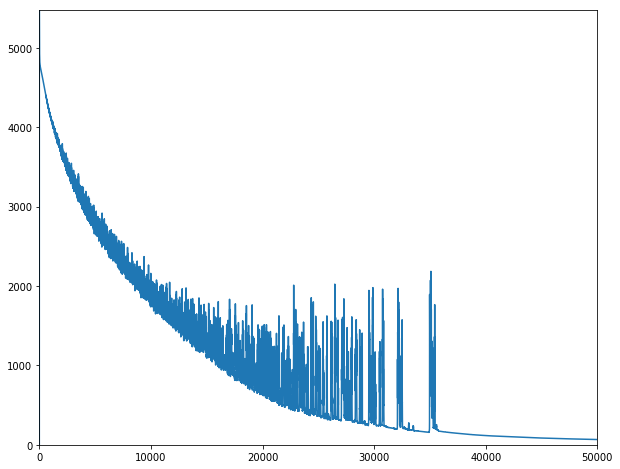

F-Score: 0.36


In [604]:
start_time = time.time()

cost_history = np.empty(shape=[1],dtype=float)
y_true, y_pred = None, None
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(training_epochs):   
        if epoch % 100 == 0:
            print(epoch, "epochs", end='\r')
        _,cost = sess.run([optimizer,cost_function],feed_dict={X_:X_train,Y:Y_train})
        cost_history = np.append(cost_history,cost)
    
    end_time = time.time()
    print("--- %s seconds ---" % (end_time - start_time))
    
    y_pred = sess.run(tf.argmax(y_,1),feed_dict={X_: X_test})
    y_true = sess.run(tf.argmax(Y_test,1))
    print("Test accuracy: ",round(sess.run(accuracy, 
                                              feed_dict={X_: X_test,Y: Y_test}),3))
    
fig = plt.figure(figsize=(10,8))
plt.plot(cost_history)
plt.axis([0,training_epochs,0,np.max(cost_history)])
plt.show()

p,r,f,s = metrics.precision_recall_fscore_support(y_true, y_pred, average="micro")
print("F-Score:", round(f,3))

In [606]:
for label, result in sorted(zip(y_true, y_pred), key=lambda x: x[0]):
    if label == result:
        print(label+1, "\t", result+1, "\t", "+")
    else:
        print(label+1, "\t", result+1)

1 	 1 	 +
1 	 1 	 +
2 	 2 	 +
2 	 40
3 	 43
3 	 3 	 +
4 	 3
4 	 4 	 +
5 	 45
5 	 13
6 	 6 	 +
6 	 46
7 	 33
7 	 24
8 	 8 	 +
8 	 8 	 +
9 	 24
9 	 9 	 +
10 	 30
10 	 30
11 	 11 	 +
11 	 31
12 	 19
12 	 13
13 	 12
13 	 19
14 	 14 	 +
14 	 11
15 	 25
15 	 12
16 	 26
16 	 17
17 	 15
17 	 16
18 	 13
18 	 18 	 +
19 	 41
19 	 11
20 	 13
20 	 20 	 +
21 	 21 	 +
21 	 27
22 	 32
22 	 42
23 	 24
23 	 43
24 	 14
24 	 35
25 	 25 	 +
25 	 25 	 +
26 	 26 	 +
26 	 26 	 +
27 	 28
27 	 29
28 	 18
28 	 27
29 	 33
29 	 23
30 	 30 	 +
30 	 7
31 	 31 	 +
31 	 35
32 	 25
32 	 32 	 +
33 	 3
33 	 9
34 	 4
34 	 33
35 	 35 	 +
35 	 35 	 +
36 	 36 	 +
36 	 7
37 	 39
37 	 10
38 	 38 	 +
38 	 37
39 	 39 	 +
39 	 39 	 +
40 	 48
40 	 40 	 +
41 	 41 	 +
41 	 8
42 	 42 	 +
42 	 13
43 	 44
43 	 43 	 +
44 	 24
44 	 43
45 	 45 	 +
45 	 6
46 	 46 	 +
46 	 46 	 +
47 	 49
47 	 44
48 	 28
48 	 28
49 	 30
49 	 49 	 +
50 	 50 	 +
50 	 21


In [ ]:
for label, s in sorted(zip(y_test, S_test), key=lambda x: x[0]):
    print(label)
    librosa.display.specshow(librosa.power_to_db(s, ref=np.max), y_axis='mel', x_axis='time')
    plt.show()